In [ ]:
import pylidc as pl
from pylidc.utils import consensus
import pandas as pd
from collections import Counter

scans = pl.query(pl.Scan).all()


luna_series_uids = pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/data/luna/metadata/seriesuids.csv', header=None)[0].values

cnt = 0
rows = []
for scan in scans:
    if scan.series_instance_uid in luna_series_uids:
        # Collect all attribute names from pylidc.Annotation
        attr_names = [
            'subtlety',
            'internalStructure',
            'calcification',
            'sphericity',
            'margin',
            'lobulation',
            'spiculation',
            'texture',
            'malignancy',
            'diameter'         
        ]

        for attr in attr_names:
            values = [getattr(a, attr) for a in scan.annotations]
            all_same = len(set(values)) == 1  # True if all values are the same
            # Compute majority value (mode); if tie, pick smallest value
            if values:
                counts = Counter(values)
                majority_value = min([v for v, c in counts.items() if c == max(counts.values())])
            else:
                majority_value = None
            rows.append({
            'scan_id': scan.series_instance_uid,
            'series_instance_uid': scan.series_instance_uid,
            'attribute': attr,
            'all_same_value': all_same,
            'majority_value': majority_value
            })
        
df = pd.DataFrame(rows)

        


986.6666666666666

In [55]:
display(df.shape[0] / 10)

888.0

In [15]:
import numpy as np

def bbox_iou(centroid1, centroid2, diameter1, diameter2):
    # centroid: (z, y, x), diameter: float
    dist = np.linalg.norm(np.array(centroid1) - np.array(centroid2))
    r1 = diameter1 / 2.0
    r2 = diameter2 / 2.0
    # If spheres do not overlap
    if dist >= r1 + r2:
        return 0.0
    # Any overlap at all returns 1.0
    return 1.0

def collate_annotations_by_overlap(scan, iou_threshold=0.1):
    annotations = scan.annotations
    bboxes = [a.centroid for a in annotations]
    diameters = [a.diameter for a in annotations]
    groups = []
    used = set()
    for i, (bbox, diameter) in enumerate(zip(bboxes, diameters)):
        if i in used:
            continue
        group = [annotations[i]]
        used.add(i)
        for j in range(i+1, len(bboxes)):
            if j in used:
                continue
            if bbox_iou(bbox, bboxes[j], diameter, diameters[j]) > iou_threshold:
                group.append(annotations[j])
                used.add(j)
        groups.append(group)
    return groups

scan_nodule_groups = {}
for scan in scans:
    if scan.series_instance_uid in luna_series_uids:
        groups = collate_annotations_by_overlap(scan)
        # Only keep groups (nodules) with at least 3 annotations
        filtered_groups = [group for group in groups if len(group) >= 2]
        scan_nodule_groups[scan.series_instance_uid] = filtered_groups


num_nodules = sum(len(groups) for groups in scan_nodule_groups.values())
print(f"Total individual nodules: {num_nodules}")

Total individual nodules: 1600


In [57]:
# Expand each annotation group so that each characteristic is a column
expanded_rows = []
attr_names = [
    # 'subtlety',
    # 'internalStructure',
    'calcification',
    'sphericity',
    'margin',
    'lobulation',
    'spiculation',
    'texture',
    'malignancy',
    'diameter'
]

for scan_id, nodule_groups in scan_nodule_groups.items():
    for nodule_idx, group in enumerate(nodule_groups):
        for annotation_idx, annotation in enumerate(group):
            row = {'scan_id': scan_id, 'nodule_idx': nodule_idx, 'annotation_idx': annotation_idx}
            for attr in attr_names:
                row[attr] = getattr(annotation, attr)
            expanded_rows.append(row)

df_nodules_expanded = pd.DataFrame(expanded_rows).sort_values(by=['scan_id', 'nodule_idx', 'annotation_idx'])
df_nodules_expanded.head(30)


,scan_id,nodule_idx,annotation_idx,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy,diameter
3574,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,0,0,6,4,5,1,1,5,4,6.971671
3575,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,0,1,6,4,4,1,1,5,2,6.971671
3576,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,0,2,6,5,5,1,1,5,4,7.348787
3577,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,0,3,6,3,4,1,1,5,2,5.942285
3578,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,1,0,6,5,5,1,1,5,3,4.908604
3579,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,1,1,6,5,3,2,2,5,1,5.314941
3580,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,1,2,6,4,5,1,1,4,3,6.445312
4365,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,0,0,6,3,4,2,2,5,4,10.915156
4366,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,0,1,6,3,4,1,1,5,3,8.948638
4367,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,0,2,6,3,3,1,1,5,1,5.896238


In [65]:
df = df_nodules_expanded.groupby(['scan_id', 'nodule_idx']).agg(
    {attr: 'mean' for attr in attr_names} | {'annotation_idx': 'count'}
)
df[attr_names] = df[attr_names].fillna(0).astype(int)  # Fill NaN values with 0
df = df.query('annotation_idx>=3')

df.head()


calcification  \
scan_id                                            nodule_idx                  
1.3.6.1.4.1.14519.5.2.1.6279.6001.1002252872223... 0                       6   
                                                   1                       6   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1003981387935... 0                       6   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1006213830162... 0                       6   
                                                   1                       6   

                                                               sphericity  \
scan_id                                            nodule_idx               
1.3.6.1.4.1.14519.5.2.1.6279.6001.1002252872223... 0                    4   
                                                   1                    4   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1003981387935... 0                    3   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1006213830162... 0                    3   
                                                   1                    4   

                                                               margin  \
scan_id                                            nodule_idx           
1.3.6.1.4.1.14519.5.2.1.6279.6001.1002252872223... 0                4   
                                                   1                4   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1003981387935... 0                3   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1006213830162... 0                4   
                                                   1                4   

                                                               lobulation  \
scan_id                                            nodule_idx               
1.3.6.1.4.1.14519.5.2.1.6279.6001.1002252872223... 0                    1   
                                                   1                    1   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1003981387935... 0                    1   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1006213830162... 0                    1   
                                                   1                    1   

                                                               spiculation  \
scan_id                                            nodule_idx                
1.3.6.1.4.1.14519.5.2.1.6279.6001.1002252872223... 0                     1   
                                                   1                     1   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1003981387935... 0                     1   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1006213830162... 0                     1   
                                                   1                     1   

                                                               texture  \
scan_id                                            nodule_idx            
1.3.6.1.4.1.14519.5.2.1.6279.6001.1002252872223... 0                 5   
                                                   1                 4   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1003981387935... 0                 5   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1006213830162... 0                 5   
                                                   1                 5   

                                                               malignancy  \
scan_id                                            nodule_idx               
1.3.6.1.4.1.14519.5.2.1.6279.6001.1002252872223... 0                    3   
                                                   1                    2   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1003981387935... 0                    2   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1006213830162... 0                    3   
                                                   1                    4   

                                                               diameter  \
scan_id                                            nodule_idx             
1.3.6.1.4.1.14519.5.2.1.6279.6001.1002252872223... 0                  6   
                                                   1                  5   
1.3.

In [48]:
attribute_mappings = {
    'subtlety': {
        1: '1 - Extremely Subtle',
        2: '2',
        3: '3 - Fairly Subtle',
        4: '4',
        5: '5 - Obvious'
    },
    'internalStructure': {
        1: 'Soft Tissue',
        2: 'Fluid',
        3: 'Fat',
        4: 'Air'
    },
    'calcification': {
        1: 'Popcorn',
        2: 'Laminated',
        3: 'Solid',
        4: 'Non-central',
        5: 'Central',
        6: 'Absent'
    },
    'sphericity': {
        1: '1 Linear',
        2: '2',
        3: '3 Ovoid',
        4: '4',
        5: '5 Round'
    },
    'margin': {
        1: '1 Poorly Defined',
        2: '2',
        3: '3 Medium Margin',
        4: '4',
        5: '5 Sharp'
    },
    'lobulation': {
        1: '1 No Lobulation',
        2: '2',
        3: '3 Medium Lobulation',
        4: '4',
        5: '5 Marked Lobulation'
    },
    'spiculation': {
        1: '1 No Spiculation',
        2: '2',
        3: '3 Medium Spiculation',
        4: '4',
        5: '5 Marked Spiculation'
    },
    'texture': {
        1: '1 Non-Solid/GGO',
        2: '2',
        3: '3 Part Solid/Mixed',
        4: '4',
        5: '5 Solid'
    },
    'malignancy': {
        1: '1 Highly Unlikely',
        2: '2',
        3: '3 Indeterminate',
        4: '4',
        5: '5 Highly Suspicious'
    }
}


In [49]:
attr_names = [
    # 'subtlety',
    # 'internalStructure',
    'calcification',
    'sphericity',
    # 'margin',
    'lobulation',
    'spiculation',
    'texture',
    'malignancy'
]

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_44535/1212875643.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(new_labels)
/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_44535/1212875643.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(new_labels)
/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_44535/1212875643.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(new_labels)
/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_44535/1212875643.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(new_labe

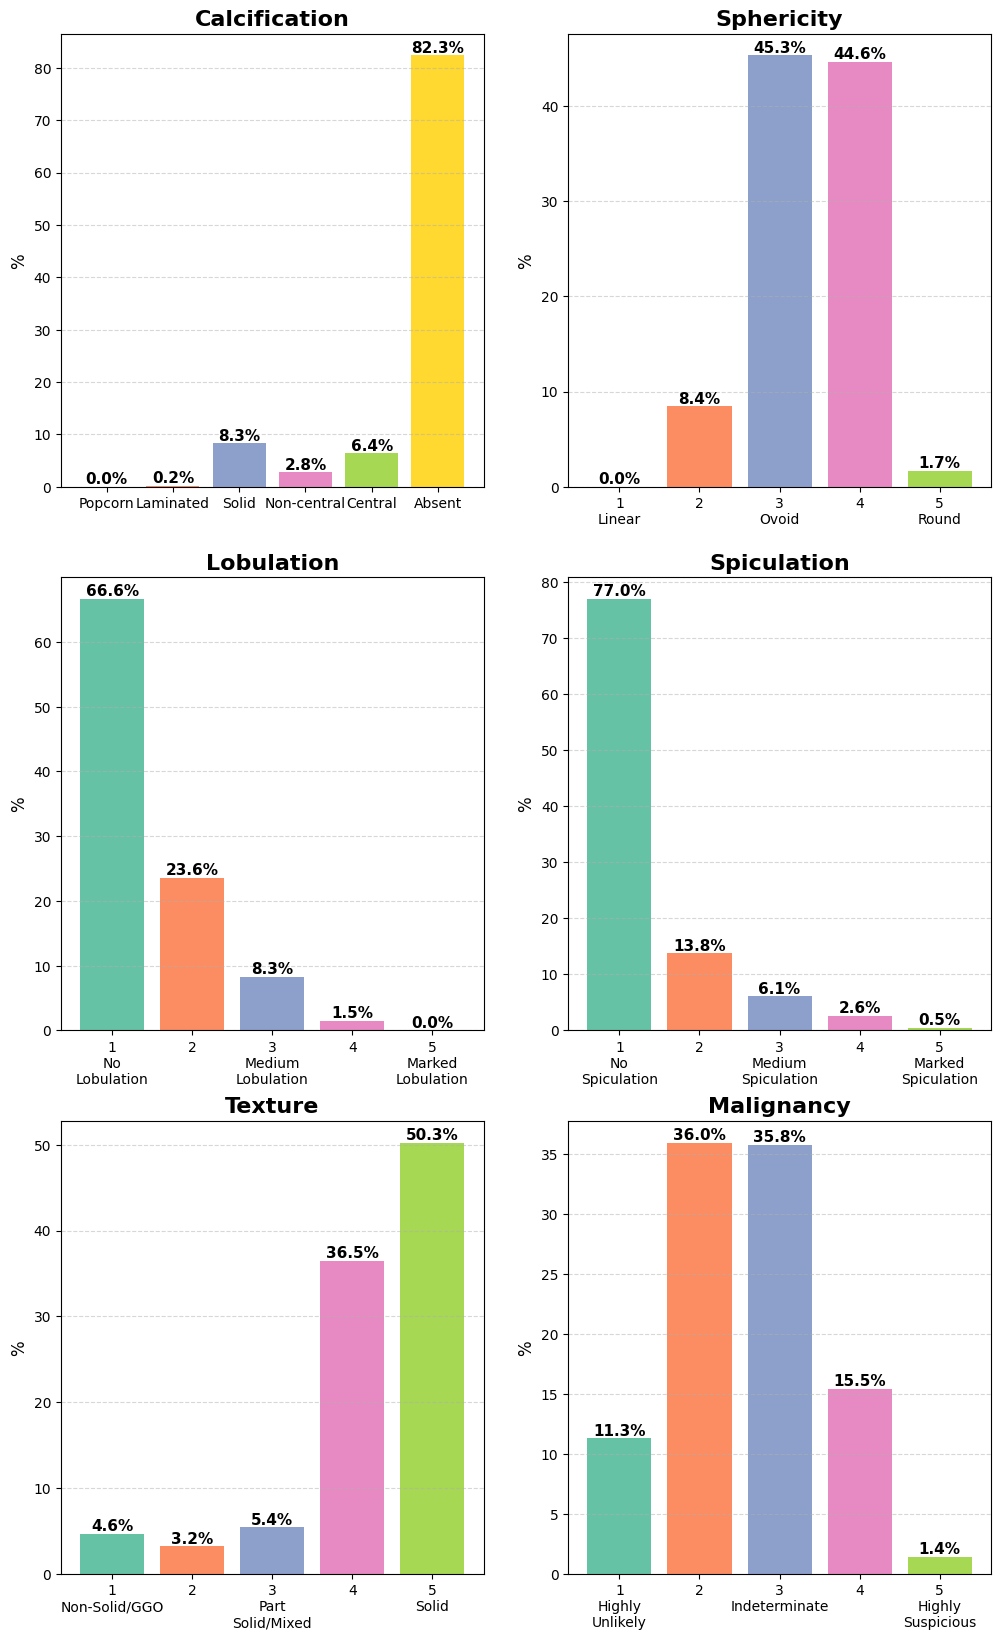

In [ ]:
import matplotlib.pyplot as plt

# Calculate percentages for each attribute
percentages = {}
for attr in attr_names:
    value_counts = df[attr].value_counts(normalize=True) * 100
    percentages[attr] = value_counts.sort_index()

# Fancy plot: color palette, grid, value labels, improved layout
color_palette = plt.cm.Set2.colors  # Use a nice colormap

fig, axes = plt.subplots(3, 2, figsize=(12, 20))
axes = axes.flatten()

for idx, attr in enumerate(attr_names):
    # Get all possible integer keys for this attribute from attribute_mappings
    possible_keys = sorted(attribute_mappings[attr].keys())
    # Convert integer labels to strings using attribute_mappings
    str_labels = [attribute_mappings[attr][k] for k in possible_keys]
    # Get values for each possible key, fill missing with 0
    values = [percentages[attr].get(k, 0) for k in possible_keys]
    bars = axes[idx].bar(
        str_labels,
        values,
        color=color_palette[:len(str_labels)]
    )
    axes[idx].set_title(attr.capitalize(), fontsize=16, fontweight='bold')
    axes[idx].set_ylabel('%', fontsize=12)
    # Add carriage return after spaces in x-tick labels
    new_labels = [lbl.replace(' ', '\n') for lbl in str_labels]
    axes[idx].set_xticklabels(new_labels)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.5)
    # Add value labels on bars
    for bar, value in zip(bars, values):
        axes[idx].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{value:.1f}%',
            ha='center',
            va='bottom',
            fontsize=11,
            fontweight='bold'
        )


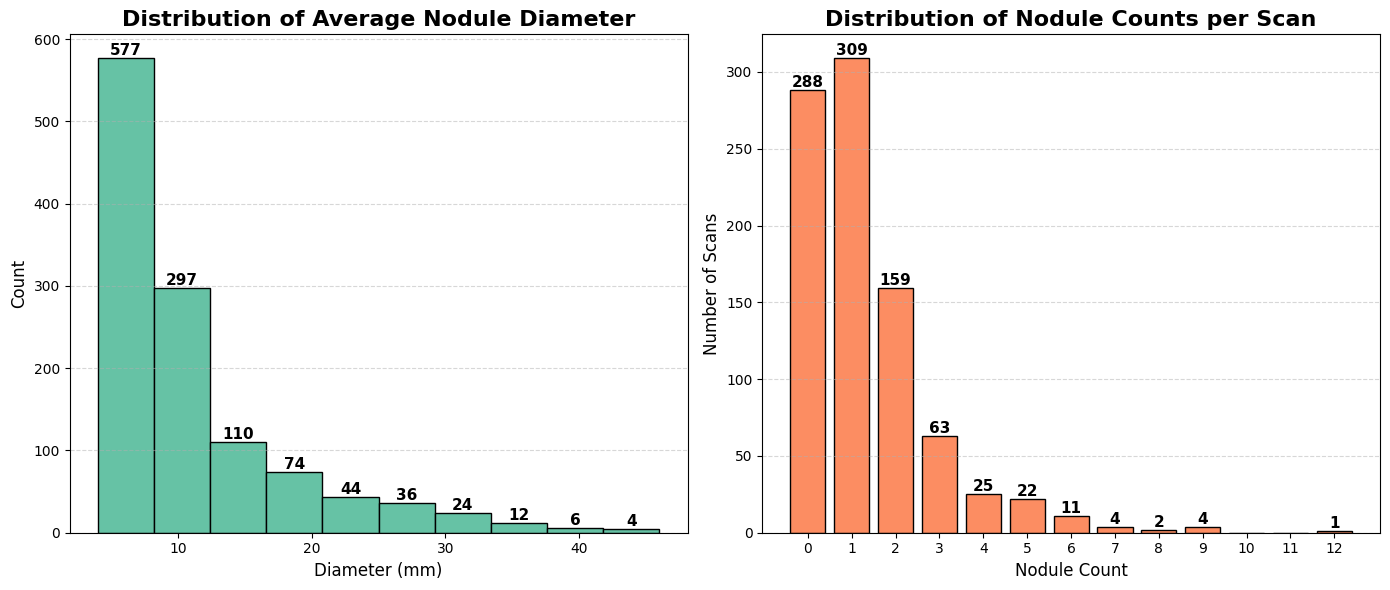

In [74]:
# Distribution of nodule counts per scan

# Convert luna_series_uids to DataFrame
luna_df = pd.DataFrame({'series_instance_uid': luna_series_uids})

# Group by scan_id and count nodules
nodule_counts = df.groupby('scan_id').size().rename_axis('series_instance_uid').reset_index(name='nodule_count')

# Merge and fill missing nodule counts with 0
merged_df = luna_df.merge(nodule_counts, on='series_instance_uid', how='left').fillna({'nodule_count': 0})
merged_df['nodule_count'] = merged_df['nodule_count'].astype(int)

# Use merged_df for histogram
nodule_counts_df = merged_df['nodule_count']

# Fancy histogram plots for nodule diameter and nodule counts per scan

color_palette = plt.cm.Set2.colors

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribution of average diameter per nodule
bars0 = axes[0].hist(df['diameter'], bins=10, color=color_palette[0], edgecolor='black')
axes[0].set_title('Distribution of Average Nodule Diameter', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Diameter (mm)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
# Add value labels on top of bars
for rect, count in zip(bars0[2], bars0[0]):
    if count > 0:
        axes[0].text(rect.get_x() + rect.get_width() / 2, count, f'{int(count)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Distribution of nodule counts per scan
bars1 = axes[1].bar(
    range(0, nodule_counts_df.max()+1),
    [nodule_counts_df.value_counts().get(i, 0) for i in range(0, nodule_counts_df.max()+1)],
    color=color_palette[1], edgecolor='black', align='center'
)
axes[1].set_title('Distribution of Nodule Counts per Scan', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Nodule Count', fontsize=12)
axes[1].set_ylabel('Number of Scans', fontsize=12)
axes[1].set_xticks(range(0, nodule_counts_df.max()+1))
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()